In [3]:
import xgboost
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin # Needed to do custom pipeline things
# import interpret

In [4]:
features_race = ['white_alone_percent_cen', 'black_alone_percent_cen',
       'indigenous_alone_percent_cen', 'asian_alone_percent_cen',
       'pacific_islander_alone_percent_cen', 'other_alone_percent_cen',
       'multiracial_percent_cen']

features_transit_type = ['work_from_home_percent_cen',
       'automobile_to_work_percent_cen', 'public_transit_to_work_percent_cen',
       'taxi_to_work_percent_cen', 'motorcycle_to_work_percent_cen',
       'bike_to_work_percent_cen', 'walk_to_work_percent_cen',
       'other_to_work_percent_cen']

features_education = ['lt_9th_percent_cen',
       'no_diploma_percent_cen', 'high_school_percent_cen',
       'some_college_percent_cen', 'associates_percent_cen',
       'bachelors_percent_cen', 'graduate_degree_percent_cen']

features_employment = ['in_labor_force_20_64_percent_cen',
       'not_in_labor_force_20_64_percent_cen', 'unemployed_20_64_percent_cen',
       'below_poverty_line_percent_cen']

features = features_race + features_transit_type + features_education + features_employment + ['median_household_income_cen',
       'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 'driving_travel_time']

In [99]:
len(features)

31

Here, we read in the training dataset.

In [5]:
data = gpd.read_file('../project_data/final_dataset/train_final_dataset_Chicago_no_outlier.geojson')
X= data[features]
y= data['VoterTurnoutPercentage']

In [6]:
data_train, data_val = train_test_split(data, test_size=0.2,random_state=170817)
X_train, y_train = data_train[features], data_train['VoterTurnoutPercentage']
X_val, y_val = data_val[features], data_val['VoterTurnoutPercentage']
# X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20)

# Plotting Features vs VoterTurnoutPercentage

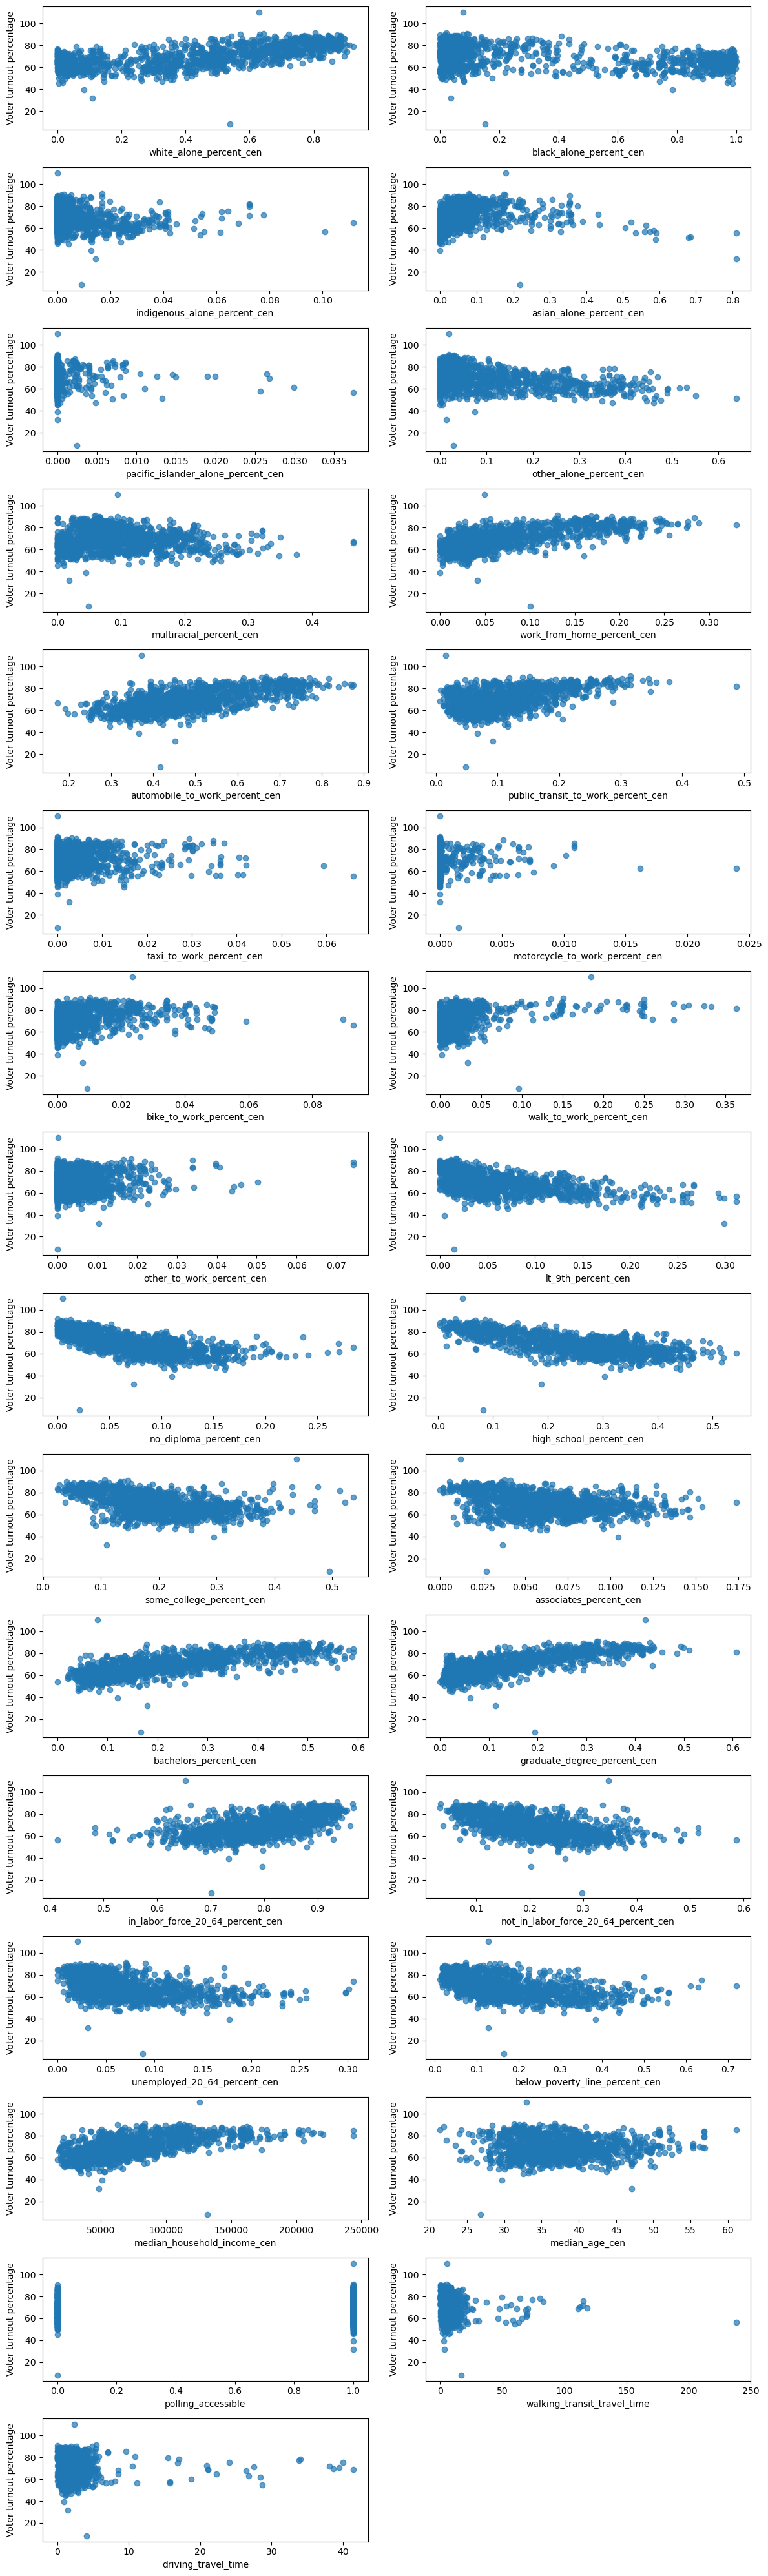

In [7]:
# Define the number of rows and columns for the grid
num_features = X_train.shape[1]
num_cols = 2  # Choose number of columns for layout
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed

# Create the grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8 + num_rows * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature against y_train
for i, column in enumerate(X_train.columns):
    axes[i].scatter(X_train[column], y_train.values, alpha=0.7)
    # axes[i].set_title(f'{column} vs VoterTurnoutPercentage')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Voter turnout percentage')
    # axes[i].set_ylabel('VoterTurnoutPercentage')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

See readme.md and EDA notebook for an explanation of the higher-than-100% turnout in a precinct. 

# Baseline model

We begin by defining a baseline model, which always predicts the mean voter turnout from all of the precincts in the training data.
The metric we'll use to guide us is simply the root mean squared error between the predicted and actual voter turnout

In [8]:
class baseline():
    def __init__(self):
        self.y_predict = None
    def fit(self, X_train,y_train):

        self.y_predict = np.mean(y_train)

    def predict(self, X_predict):
        return self.y_predict * np.ones(len(X_predict))
        

        
        
    

In [9]:

base = baseline()
base.fit(X_train, y_train)
y_predict_base = base.predict(X_val)
rmse_base = root_mean_squared_error(y_predict_base, y_val)
print(rmse_base)

9.488627038967632


So the number to beat is ~9-10% (after rerunning a few times)

# Linear regression

We won't spend much time on this (see the statsmodels section below for a slightly deeper dive), as we have good reason to 
believe that the problem is best thought of as a logistic regression problem 
(how probable is it that a person in a precinct will vote vs. stay at home). But we start by blindly throwing 
linear regression at all of the features to see how it does.

In [10]:
pipe_lr = Pipeline([('scale',StandardScaler()),('reg',LinearRegression())])
pipe_lr.fit(X_train,y_train)
y_predict_lr = pipe_lr.predict(X_val)
rmse_lr = root_mean_squared_error(y_predict_lr, y_val)
print(rmse_lr)

5.095992745301886


# XGBoost

We'd like to try an ensemble method, and choose XGBoost to look at feature importance, which we later verify with other methods
Here we search for the optimal maximum depth, number of weak learners, and learning rates

In [ ]:

depths = range(1,6)
learning_rates = np.linspace(0,.2,5)
learning_rates[0] = 0.01
# rmses will hold the cross validation score of each model.
rmses = np.zeros((len(depths),len(learning_rates)))
models = []

for j, depth in enumerate(depths):
    sub_models = []
    print('depth {}'.format(j))
    for k, learning_rate in enumerate(learning_rates):
        print('rate {}'.format(k))

        xgb_reg = xgboost.XGBRegressor(learning_rate=learning_rate,
                               max_depth=depth,
                               n_estimators=150,verbosity=0, early_stopping_rounds=10)
        sub_models.append(xgb_reg)
        xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        y_predict_xgb = xgb_reg.predict(X_val)
        rmses[j,k] = root_mean_squared_error(y_predict_xgb, y_val)
    models.append(sub_models)

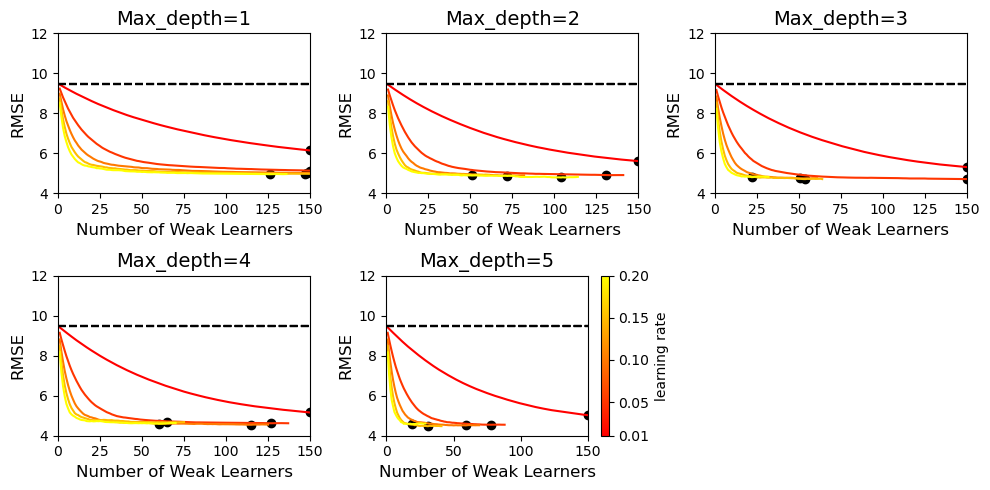

In [12]:
import matplotlib
from matplotlib.cm import ScalarMappable

colormap = plt.cm.autumn
normalize = matplotlib.colors.Normalize(vmin=learning_rates[0], vmax=learning_rates[-1])
colors=colormap(normalize(learning_rates))
fig = plt.figure(figsize=(10,5))

for ii, sub_models in enumerate(models):
    ax = fig.add_subplot(2,3,ii+1)
    for jj, xgb_reg in enumerate(sub_models):
        ax.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
                 xgb_reg.evals_result()['validation_0']['rmse'],label=learning_rates[jj],color=colors[jj])
        ax.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
                    [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')


        ax.axhline(rmse_base, 0,200, linestyle='--',color = 'k')

        ax.set_title("Max_depth={}".format(depths[ii]), fontsize=14)
        ax.set_xlabel("Number of Weak Learners", fontsize=12)
        ax.set_ylabel("RMSE", fontsize=12)
        ax.set_xlim(0,150)
        ax.set_ylim(4,12)#
        #if ii==4: ax.legend(loc=3)
fig.colorbar(ScalarMappable(cmap=colormap, norm=normalize), ticks=learning_rates, label='learning rate',ax=ax)
plt.tight_layout()
plt.show()

Most of the models bottom out, but the slowest learning models still have room for improvement. The max depth doesn't seem to change much, but let's run the slowest model with an expanded range of max depths and more learners to see if there's any improvement

In [13]:
for ii, rmse_set in enumerate(rmses):
    print('depth {}:'.format(depths[ii]),'rate {}'.format(learning_rates[np.argmin(rmse_set)]), 'rmse: {}'.format(min(rmse_set)))

depth 1: rate 0.2 rmse: 4.951074370672656
depth 2: rate 0.2 rmse: 4.787997986115081
depth 3: rate 0.15000000000000002 rmse: 4.706115551510129
depth 4: rate 0.1 rmse: 4.5485329014000895
depth 5: rate 0.15000000000000002 rmse: 4.476005673102524


In [ ]:

depths = range(1,10)


rmses_low_lr = np.zeros(len(depths))
models_low_lr = []

for j, depth in enumerate(depths):
    

    xgb_reg = xgboost.XGBRegressor(learning_rate=.01,
                               max_depth=depth,
                               n_estimators=1000,verbosity=0,early_stopping_rounds=10)
    xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_predict_xgb = xgb_reg.predict(X_val)
    rmses_low_lr[j] = root_mean_squared_error(y_predict_xgb, y_val)

    models_low_lr.append(xgb_reg)



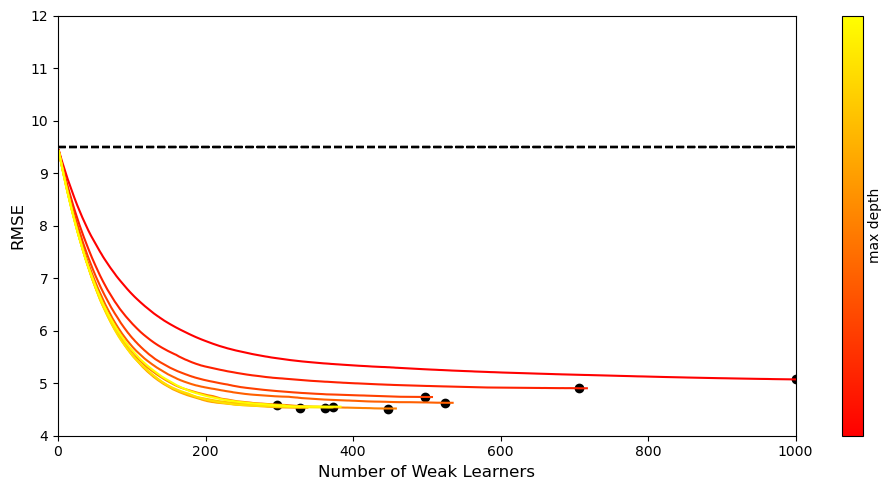

In [15]:
import matplotlib
from matplotlib.cm import ScalarMappable

colormap = plt.cm.autumn
normalize = matplotlib.colors.Normalize(vmin=depths[0], vmax=depths[-1])
colors=colormap(normalize(depths))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
for ii, xgb_reg in enumerate(models_low_lr):

    ax.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
                 xgb_reg.evals_result()['validation_0']['rmse'],label=depths[ii],color=colors[ii])
    ax.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
                    [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')


    ax.axhline(rmse_base, 0,200, linestyle='--',color = 'k')

    ax.set_xlabel("Number of Weak Learners", fontsize=12)
    ax.set_ylabel("RMSE", fontsize=12)
    ax.set_xlim(0,1000)
    ax.set_ylim(4,12)#
        #if ii==4: ax.legend(loc=3)
fig.colorbar(ScalarMappable(cmap=colormap, norm=normalize), ticks=learning_rates, label='max depth',ax=ax)
plt.tight_layout()
plt.show()

In [16]:
for ii, rmse_low_lr in enumerate(rmses_low_lr):
    print('depth {}:'.format(depths[ii]),'rmse: {}'.format(rmse_low_lr))

depth 1: rmse: 5.071906689967429
depth 2: rmse: 4.901918623881179
depth 3: rmse: 4.736349094828326
depth 4: rmse: 4.626331306896076
depth 5: rmse: 4.517769994642569
depth 6: rmse: 4.53205912720404
depth 7: rmse: 4.583437594232005
depth 8: rmse: 4.53583319250878
depth 9: rmse: 4.552406526819729


So it looks like a max depth of 5 is optimal, but the best performing model is marginally the one with a higher learning rate of .15

In [17]:
xgb_reg_opt = models[-1][3]
rmse_xgb_opt = rmses[-1][3]

In [18]:
print(rmse_xgb_opt)

4.476005673102524


Let's look at which features ended up being most important

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

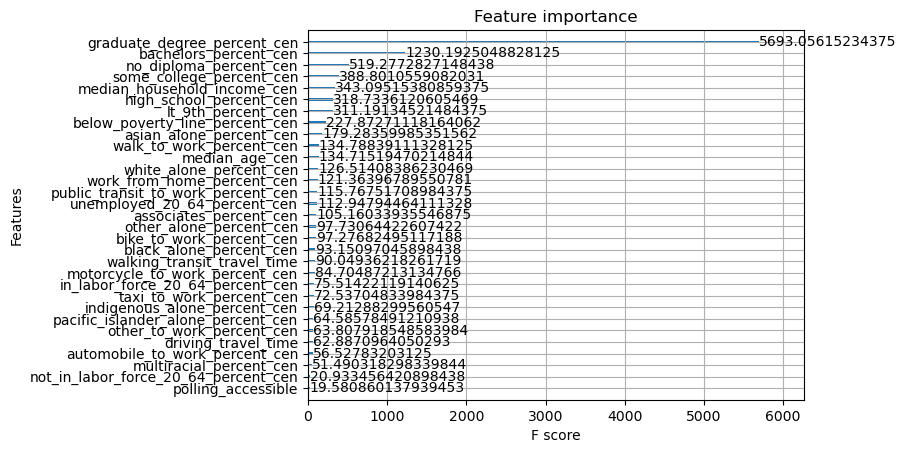

In [19]:
xgboost.plot_importance(xgb_reg_opt, importance_type = 'gain')

It looks like the features related to level of education in a precinct are the most important in determining voter turnout, followed by income-related statistics

In [20]:
print('Baseline RMSE: {}'.format(rmse_base))
print('Linear Regression RMSE: {}'.format(rmse_lr))
print('XGBoost RMSE: {}'.format(rmse_xgb_opt))

Baseline RMSE: 9.488627038967632
Linear Regression RMSE: 5.095992745301886
XGBoost RMSE: 4.476005673102524


# Using `statsmodels` and linear regression to look at feature importance 

According to the results in this section, we find that essentially all of the features have significant influence on voter turnout. This aligns with what we found from the XGBoost section and the (categorical) Logistic Regression section.

In [21]:
import statsmodels.api as sm

In [22]:
# First, scale the data.
scaler = StandardScaler()
X_train_scaled = gpd.GeoDataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

full_model = sm.OLS(y_train.values, sm.add_constant(X_train_scaled).values).fit()

def perform_f_test(X, full_features, reduced_features):
    X_train_full = X[full_features]
    X_train_reduced = X[reduced_features]

    # Create the models
    full_model = sm.OLS(y_train.values, sm.add_constant(X_train_full).values).fit()
    reduced_model = sm.OLS(y_train.values, sm.add_constant(X_train_reduced).values).fit()

    # Perform the F-test
    f_test = full_model.compare_f_test(reduced_model)

    # Print the results
    print("F-statistic:", f_test[0])
    print("p-value:", f_test[1])

### Travel time only
First, we use the reduced model with only the features `'walking_transit_travel_time'` and `'driving_travel_time'`.

In [23]:
perform_f_test(X_train_scaled, features, ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 112.74453246657329
p-value: 2.60149161939858e-309


Evidently, we should reject the reduced model.

### Education/Employment only

In [24]:
perform_f_test(X_train_scaled, features, features_education + features_employment)

F-statistic: 9.761661081815294
p-value: 3.907577694993163e-27


Evidently, we should reject the reduced model.

### Education/Employment + travel time only

In [25]:
perform_f_test(X_train_scaled, features, features_education + features_employment + ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 10.401915510945917
p-value: 1.2938919356872215e-26


Evidently, we should reject the reduced model.

### Education/Employment + travel time only + median income

In [26]:
perform_f_test(X_train_scaled, features, features_education + features_employment 
               + ['walking_transit_travel_time', 'driving_travel_time', 'median_household_income_cen'])

F-statistic: 10.86869606418049
p-value: 1.3260987066690702e-26


### All but race

In [27]:
perform_f_test(X_train_scaled, features, features_transit_type + features_education + features_employment 
               + ['median_household_income_cen', 'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 
                  'driving_travel_time'])

F-statistic: 21.076113709557866
p-value: 1.1018569866966927e-23


# Logistic Regression (Categorical)

## Unweighted Categorical

We use logistic regression. We see below that the median voter turnout percentage is approximately 70, so we used that as a cutoff percentage for labelling.

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
print(data['VoterTurnoutPercentage'].median())
cutoff_percentage = 70

69.265


In [30]:
# A function to create the labels based on the cutoff percentage.
def make_labels(y_train):
    return 1.0*(y_train >= cutoff_percentage)

# Create the pipeline.
pipe_logr = Pipeline([('scale', StandardScaler()),
                      ('logr', LogisticRegression())])

# Do the logistic regression.
pipe_logr.fit(X_train, make_labels(y_train))

# Score!
pipe_logr.score(X_val, make_labels(y_val))

0.8303030303030303

As can be seen from the bar chart below, the features like `graduate_degree_percent_cen` and `high_school_percent_cen` have the most impact on voter turnout (or more precisely, whether the voter turnout is above 70%). This aligns with the results of XGBoost.

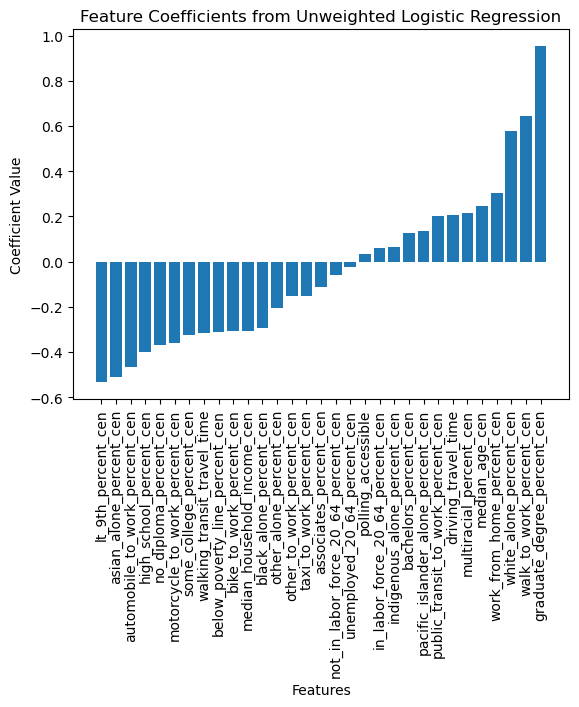

In [62]:
# Create the dictionary of feature names and coefficients
coeff_dict_logr = dict(zip(features, pipe_logr.named_steps['logr'].coef_[0]))

# Convert the dictionary to a DataFrame
coeff_df_logr = pd.DataFrame(coeff_dict_logr.items(), columns=['Feature', 'Coefficient'])

coeff_df_logr.sort_values('Coefficient', inplace=True)
xx = np.arange(coeff_df_logr.shape[0])
plt.bar(xx, coeff_df_logr['Coefficient'])
plt.gca().xaxis.set_ticks(xx)
plt.gca().xaxis.set_ticklabels(coeff_df_logr['Feature'], rotation=90)

# Add titles and labels
plt.title('Feature Coefficients from Unweighted Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

plt.show()

## Weighted Categorical
The only difference here is that we're weighting each precinct by `total_population_cen`.

In [32]:
def make_weights(data):
    return data['total_population_cen']

# Create the pipeline.
pipe_wt_logr = Pipeline([('scale', StandardScaler()),
                         ('wt_logr', LogisticRegression())])

# Do the logistic regression.
pipe_wt_logr.fit(X_train, make_labels(y_train), wt_logr__sample_weight=data_train['total_population_cen'])

# Score!
pipe_wt_logr.score(X_val, make_labels(y_val), wt_logr__sample_weight=data_val['total_population_cen'])

0.8303030303030303

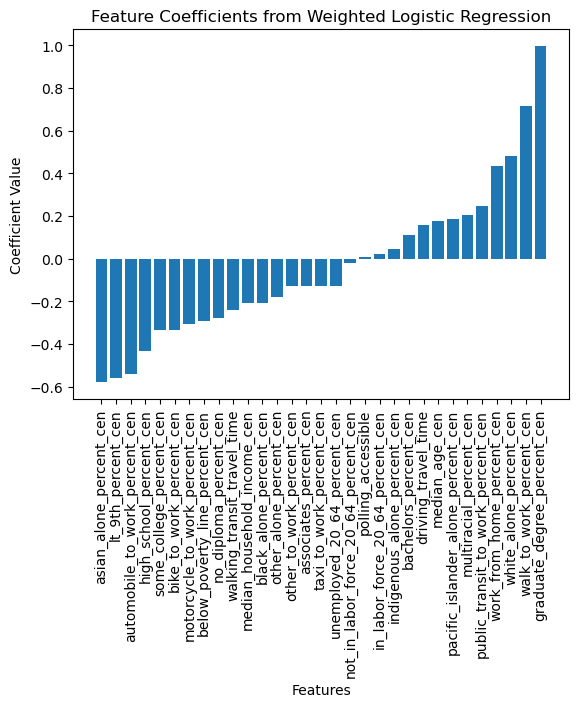

In [ ]:
# Create the dictionary of feature names and coefficients
coeff_dict_wt_logr = dict(zip(features, pipe_wt_logr.named_steps['wt_logr'].coef_[0]))

# Convert the dictionary to a DataFrame
coeff_df_wt_logr = pd.DataFrame(coeff_dict_wt_logr.items(), columns=['Feature', 'Coefficient'])

coeff_df_wt_logr.sort_values('Coefficient', inplace=True)
xx = np.arange(coeff_df_wt_logr.shape[0])
plt.bar(xx, coeff_df_wt_logr['Coefficient'])
plt.gca().xaxis.set_ticks(xx)
plt.gca().xaxis.set_ticklabels(coeff_df_wt_logr['Feature'], rotation=90)

# Add titles and labels
plt.title('Feature Coefficients from Weighted Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

plt.show()

## Cross Validation

In [34]:
kfold_logr = KFold(n_splits=5, shuffle=True)
X_train_with_pop = data_train[features + ['total_population_cen']]

# scores will hold the cross validation score of each model.
scores = np.zeros((2,5))

for i, (train_index, val_index) in enumerate(kfold_logr.split(X_train_with_pop, y_train)):
    ## get the kfold training data
    X_train_train = X_train_with_pop.iloc[train_index,:][features]
    sample_weight_train = X_train_with_pop.iloc[train_index,:]['total_population_cen']
    y_train_train = y_train.iloc[train_index]
    
    ## get the holdout data
    X_train_holdout = X_train_with_pop.iloc[val_index,:][features]
    sample_weight_holdout = X_train_with_pop.iloc[val_index,:]['total_population_cen']
    y_train_holdout = y_train.iloc[val_index]

    ## train the models
    pipe_logr.fit(X_train_train, make_labels(y_train_train))
    pipe_wt_logr.fit(X_train_train, make_labels(y_train_train), wt_logr__sample_weight=sample_weight_train)

    ## compute the scores
    scores[0,i] = pipe_logr.score(X_train_holdout, make_labels(y_train_holdout))
    scores[1,i] = pipe_wt_logr.score(X_train_holdout, make_labels(y_train_holdout), wt_logr__sample_weight=sample_weight_holdout)

In [35]:
scores

array([[0.81439394, 0.82509506, 0.84790875, 0.82509506, 0.87072243],
       [0.81818182, 0.82509506, 0.83269962, 0.83269962, 0.87072243]])

Evidently, the weighted logistic regression performs basically exactly as well as the unweighted logistic regression.

### Comparing the coefficients
Except for `unemployed_20_64_percent_cen` (which in both models has almost not effect), the features which are negatively correlated with `VoterTurnoutPercentage>=70` and positively correlated with `VoterTurnoutPercentage>=70`, respectively, are the same in both models.

`graduate_degree_percent_cen` is  the largest contributor for both. All changes in the order of the sorted list of coefficients from one model to the other is explained by some features contributing a similar amounnt (read: their coefficients are approximately the same).

In [36]:
coeff_df_logr.merge(coeff_df_wt_logr, on='Feature')

,Feature,Coefficient_x,Coefficient_y
0,automobile_to_work_percent_cen,-0.530364,-0.654390
1,lt_9th_percent_cen,-0.477626,-0.521572
2,asian_alone_percent_cen,-0.452011,-0.513022
3,high_school_percent_cen,-0.438622,-0.467977
4,no_diploma_percent_cen,-0.354597,-0.289086
5,walking_transit_travel_time,-0.340830,-0.306174
6,other_alone_percent_cen,-0.318557,-0.285264
7,motorcycle_to_work_percent_cen,-0.289618,-0.246762
8,black_alone_percent_cen,-0.282306,-0.217739
9,bike_to_work_percent_cen,-0.274484,-0.303272


### Choosing a logistic regression model
Based on the above analysis in this section, adding the weights makes no appreciable difference. So, we suggest using the unweighted logistic regression model.

# Logistic Regression (Non-Categorical)

We use weighted logistic regression. The labels are "1" for "voted" and "0" for "didn't vote". The weights for "1" are
$$ \frac{\mathrm{VoterTurnoutPercentage}}{100} \cdot \mathrm{\mathrm{total\_population}},$$
while the weights for "0" are
$$ \left(1 - \frac{\mathrm{VoterTurnoutPercentage}}{100}\right) \cdot \mathrm{\mathrm{total\_population}}.$$

WARNING! We're using `total_population` rather than `elligible_voting_population`, since we didn't pull the latter.

In [37]:
class DataDuplicator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_duplicated = np.vstack([X, X])
        return X_duplicated

def make_labels(X):
    # 0's come first!
    return np.concatenate([np.zeros(len(X)), np.ones(len(X))])

def make_weights(pop, turnout):
    return pd.concat([(1-turnout/100) * pop,
                      turnout/100 * pop])

In [38]:
pipe_logr2 = Pipeline([('scale', StandardScaler()),
                      ('dup', DataDuplicator()),
                      ('logr', LogisticRegression())])

pipe_logr2.fit(X_train, make_labels(X_train), 
               logr__sample_weight=make_weights(data_train['total_population_cen'], y_train))
predictions_logr2 = pipe_logr2.predict_proba(X_val)[:len(X_val),1]
100 * root_mean_squared_error(predictions_logr2, y_val/100)

np.float64(5.176743537385016)

We now look at the feature importance for this model. As expected, the importance of the features is comparable to that for all our other models.

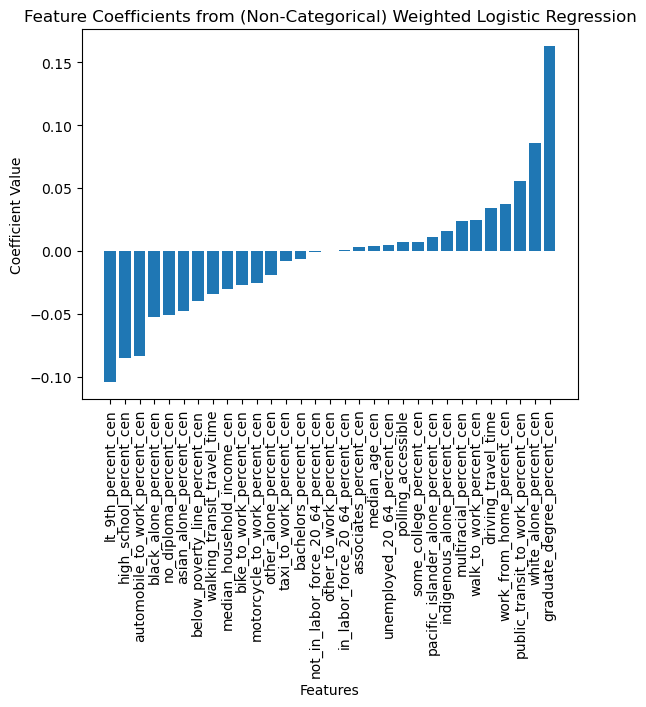

In [63]:
# Create the dictionary of feature names and coefficients
coeff_dict_logr2 = dict(zip(features, pipe_logr2.named_steps['logr'].coef_[0]))

# Convert the dictionary to a DataFrame
coeff_df_logr2 = pd.DataFrame(coeff_dict_logr2.items(), columns=['Feature', 'Coefficient'])

coeff_df_logr2.sort_values('Coefficient', inplace=True)
xx = np.arange(coeff_df_logr2.shape[0])
plt.bar(xx, coeff_df_logr2['Coefficient'])
plt.gca().xaxis.set_ticks(xx)
plt.gca().xaxis.set_ticklabels(coeff_df_logr2['Feature'], rotation=90)

# Add titles and labels
plt.title('Feature Coefficients from (Non-Categorical) Weighted Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

plt.show()

# Logistic Regression (Non-Categorical) vs. Linear Regression

We see below that there's no appreciable difference in performance between the logistic regression and the linear regression.

In [40]:
kfold = KFold(n_splits=5, shuffle=True)

# rmses will hold the cross validation score of each model.
rmses = np.zeros((2,5))

for i, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    ## get the kfold training data
    cv_X_train = X_train.iloc[train_index,:]
    cv_y_train = y_train.iloc[train_index]

    ## get the weights
    sample_weight_train = make_weights(data_train.iloc[train_index,:]['total_population_cen'], cv_y_train)
    
    ## get the holdout data
    cv_X_holdout = X_train.iloc[val_index,:][features]
    cv_y_holdout = y_train.iloc[val_index]

    ## train the models
    pipe_logr2.fit(cv_X_train, make_labels(cv_y_train), logr__sample_weight=sample_weight_train)
    pipe_lr.fit(cv_X_train, cv_y_train)

    ## predict
    predictions_logr2 = pipe_logr2.predict_proba(cv_X_holdout)[:len(cv_X_holdout),1] # Remember that the pipe duplicates X!
    predictions_lr = pipe_lr.predict(cv_X_holdout)

    ## compute the rmses
    rmses[0, i] = 100 * root_mean_squared_error(predictions_logr2, cv_y_holdout/100)
    rmses[1, i] = root_mean_squared_error(predictions_lr, cv_y_holdout)
    

In [41]:
rmses

array([[5.19184379, 6.49514809, 5.47213628, 5.00033323, 5.47516619],
       [5.18176711, 6.39536683, 5.44001335, 5.02929956, 5.34107647]])

### Comparison at the extremes

Notice that the two models perform essentially the same even at the upper extreme. This is likely because there is very little data at the extremes, which is why for us "upper extreme" is ">85" and "lower extreme" is "<60".

First, we retrain the models (since they were trained on various pieces during the cross validation).

In [42]:
pipe_lr.fit(X_train,y_train)
pipe_logr2.fit(X_train, make_labels(X_train), 
               logr__sample_weight=make_weights(data_train['total_population_cen'], y_train))

Pipeline(steps=[('scale', StandardScaler()), ('dup', DataDuplicator()),
                ('logr', LogisticRegression())])

Next, we look at the upper extremes.

In [43]:
data_val_upper = data_val.loc[data_val['VoterTurnoutPercentage'] > 85]
X_val_upper = data_val_upper[features]
y_val_upper = data_val_upper['VoterTurnoutPercentage']

In [44]:
predictions_logr2 = pipe_logr2.predict_proba(X_val_upper)[:len(X_val_upper),1]
predictions_lr = pipe_lr.predict(X_val_upper)
100 * root_mean_squared_error(predictions_logr2, y_val_upper/100), root_mean_squared_error(predictions_lr, y_val_upper)

(np.float64(6.080639711965638), np.float64(5.378164129300341))

Now, the lower extremes.

In [45]:
data_val_lower = data_val.loc[data_val['VoterTurnoutPercentage'] < 60]
X_val_lower = data_val_lower[features]
y_val_lower = data_val_lower['VoterTurnoutPercentage']

In [46]:
predictions_logr2 = pipe_logr2.predict_proba(X_val_lower)[:len(X_val_lower),1]
predictions_lr = pipe_lr.predict(X_val_lower)
100 * root_mean_squared_error(predictions_logr2, y_val_lower/100), root_mean_squared_error(predictions_lr, y_val_lower)

(np.float64(6.683965227330746), np.float64(6.332552760016773))

# Final Analysis

Although the logistic and linear regression models perform similarly, the logistic model is philosophically better. In particular, it prevents us from predicting voter turnout percentages >100% or <0%.

In [47]:
data_train = gpd.read_file('../project_data/final_dataset/train_final_dataset_Chicago_no_outlier.geojson')
X_train = data_train[features]
y_train = data_train['VoterTurnoutPercentage']

data_test = gpd.read_file('../project_data/final_dataset/test_final_dataset_Chicago_no_outlier.geojson')
X_test = data_test[features]
y_test = data_test['VoterTurnoutPercentage']

First, we train each of our models on the entire training set. Then, we use the model to predict on the test set.

In [48]:
#Baseline

base = baseline()
base.fit(X_train, y_train)
y_predict_base_test = base.predict(X_test)
rmse_base_test = root_mean_squared_error(y_predict_base_test, y_test)
#Linear Regression
pipe_lr = Pipeline([('scale',StandardScaler()),('reg',LinearRegression())])
pipe_lr.fit(X_train,y_train)
y_predict_lr_test = pipe_lr.predict(X_test)
rmse_lr_test = root_mean_squared_error(y_predict_lr_test, y_test)
#XGBoost Regression
xgb_reg = xgboost.XGBRegressor(learning_rate=.15,
                           max_depth=5,
                           n_estimators=150,verbosity=0)
xgb_reg.fit(X_train, y_train)
y_predict_xgb_test = xgb_reg.predict(X_test)
rmse_xgb_test = root_mean_squared_error(y_predict_xgb_test, y_test)

# Logistic Regression

pipe_logr2.fit(X_train, make_labels(X_train), 
               logr__sample_weight=make_weights(data_train['total_population_cen'], y_train))
predictions_logr2 = pipe_logr2.predict_proba(X_test)[:len(X_test),1]
rmse_logr2_test = 100 * root_mean_squared_error(predictions_logr2, y_test/100)

The rmse is around 5%, which is about the same as in the Logistic Regression (Non-Categorical) section.

In [49]:
print('Baseline RMSE: {}'.format(rmse_base_test))
print('Linear Regression RMSE: {}'.format(rmse_lr_test))
print('XGBoost RMSE: {}'.format(rmse_xgb_test))
print('Logistic Regression RMSE: {}'.format(rmse_logr2_test))

Baseline RMSE: 9.35970982381065
Linear Regression RMSE: 5.11103087133135
XGBoost RMSE: 5.4567709400852475
Logistic Regression RMSE: 5.1188470931565675


In [50]:
print('Linear Regression RMSE reduction: {}'.format((rmse_lr_test-rmse_base_test)/rmse_base_test))
print('XGBoost RMSE reduction: {}'.format((rmse_xgb_test-rmse_base_test)/rmse_base_test))
print('Logistic Regression RMSE reduction: {}'.format((rmse_logr2_test-rmse_base_test)/rmse_base_test))

Linear Regression RMSE reduction: -0.4539327642050255
XGBoost RMSE reduction: -0.41699357749281013
Logistic Regression RMSE reduction: -0.45309767188140093


So at the end of the day, well-thought out logistic regression and blind linear regression perform the best.
Going forward though, we would advocate for using the model that is most appropriate for the problem, which is logistic regression.